# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ddpg_agent import Agent
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def ddpg(n_episodes=2000, max_t=6000):
    agents = [Agent(state_size, action_size, random_seed=2) for _ in range(num_agents)]
    scores = []                                            # list containing scores from each episode
    scores_deque = deque(maxlen=100)                       # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state (for each agent)
        scores_episode = np.zeros(num_agents)              # initialize the score (for each agent)

        for t in range(max_t):
            for agent in agents:
                agent.reset()
            
            actions = []
            for agent, state in zip(agents, states):
                actions.append(agent.act(state))           # select an action (for each agent)
            env_info = env.step(actions)[brain_name]       # send all actions to the environment
            next_states = env_info.vector_observations     # get the current state (for each agent)
            rewards = env_info.rewards                     # get reward (for each agent)
            dones = env_info.local_done                    # see if episode finished
            
            for agent, state, action, reward, next_state, done in \
            zip(agents, states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            scores_episode += rewards                      # update the score (for each agent)
            states = next_states                           # roll over states to next time step
            if np.any(dones):                              # exit loop if episode finished
                break 
        
        score = scores_episode.max()
        scores_deque.append(score)                         # save maximum recent score
        avg = np.mean(scores_deque) 
        scores.append(avg)          
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg))
        if avg>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg))
            torch.save(agents[0].actor_local.state_dict(), '1_checkpoint_actor.pth')
            torch.save(agents[0].critic_local.state_dict(), '1_checkpoint_critic.pth')
            torch.save(agents[1].actor_local.state_dict(), '2_checkpoint_actor.pth')
            torch.save(agents[1].critic_local.state_dict(), '2_checkpoint_critic.pth')
            break
    return scores

In [6]:
scores = ddpg()
env.close()

/home/marcin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.02
Episode 900	Average Score: 0.02
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.11
Episode 1400	Average Score: 0.28
Episode 1460	Average Score: 0.51
Environment solved in 1460 episodes!	Average Score: 0.51


In [7]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

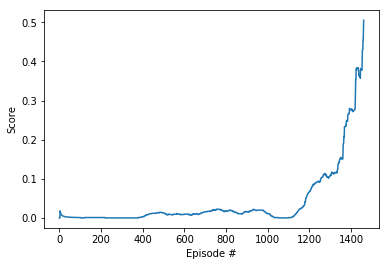

In [8]:
plot_scores(scores)

In [5]:
avg_score = []
scores_deque = deque(maxlen=100)

agents = [Agent(state_size, action_size, random_seed=2) for _ in range(num_agents)]

# load the weights from files
agents[0].actor_local.load_state_dict(torch.load('1_checkpoint_actor.pth'))
agents[0].critic_local.load_state_dict(torch.load('1_checkpoint_critic.pth'))
agents[1].actor_local.load_state_dict(torch.load('2_checkpoint_actor.pth'))
agents[1].critic_local.load_state_dict(torch.load('2_checkpoint_critic.pth'))

states = env_info.vector_observations
scores = np.zeros(num_agents) 

for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    for j in range(6000):
        for agent in agents:
            agent.reset()
        actions = []
        for agent, state in zip(agents, states):
            actions.append(agent.act(state))               # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    score = np.mean(scores)        
    avg_score.append(score)
    scores_deque.append(score)
    avg = np.mean(scores_deque)
    print('\rAverage Score: {:.2f}'.format(avg,), end="\n")

/home/marcin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Average Score: 0.15
Average Score: 0.17
Average Score: 0.19
Average Score: 0.24
Average Score: 0.28
Average Score: 0.32
Average Score: 0.73
Average Score: 1.37
Average Score: 1.88
Average Score: 2.30


In [6]:
env.close()

The Deep Deterministic Policy Gradient (DDPG) algorithm was used in the solution.
The DDPG is another Actor-Critic method which can be seen as approximate DQN or
DQN method for continuous action spaces. Critic in DDPG is used to approximate 
the maximizer over the Q-values of the next state.

The project uses following hyper-parameters:
* BUFFER_SIZE = int(1e5)  # replay buffer size
* BATCH_SIZE = 256        # minibatch size
* GAMMA = 0.9             # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR_ACTOR = 1e-3         # learning rate of the actor
* LR_CRITIC = 1e-3        # learning rate of the critic
* WEIGHT_DECAY = 1e-6     # L2 weight decay
* n_episodes = 2000       # maximum number of episodes
* max_t = 6000            # max steps per episode
* NETWORK_SIZE = 256

Agent uses following neural network architecture:
```
fc1 = nn.Linear(state_size, NETWORK_SIZE)
fc2 = nn.Linear(NETWORK_SIZE, NETWORK_SIZE)
fc3 = nn.Linear(NETWORK_SIZE, action_size)
x = F.relu(fc1(state))
x = F.relu(fc2(x))
x = F.tanh(fc3(x))
```
Critic uses following neural network architecture:
```
fcs1 = nn.Linear(state_size, NETWORK_SIZE)
fc2 = nn.Linear(NETWORK_SIZE+action_size, NETWORK_SIZE)
fc3 = nn.Linear(NETWORK_SIZE, 1)
xs = F.relu(fcs1(state))
x = torch.cat((xs, action), dim=1)
x = F.relu(fc2(x))
x = fc3(x)
```

While testing the project various experiments were executed especially with
NETWORK_SIZE. Tests used NETWORK_SIZE set to:
* 64 - never were able to solve the environment with defined criteria - 
assuming network has limited capacity),
* 128 - most of the times it was possible to solve the environment within ~35 min,
* 256 - all the times were able to solve environment within ~70 min.

For future work it is worth to:
* play more around hyper-parameters
* implement different algorithm such as PPO, A3C, D4PG.

 